<a href="https://colab.research.google.com/github/ansid0102/DA_PROJECT/blob/main/Capstone_50__accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
# Extracting the dataset
from zipfile import ZipFile

with ZipFile('/content/drive/MyDrive/CAPSTONE/archive.zip','r') as zObject:
  zObject.extractall(path='/content/data')

In [2]:
# Seeing What is inside the data directory 
data_dir = '/content/data'
print(os.listdir(data_dir))
classes = os.listdir(data_dir+"/train")
print(classes)

['test', 'train']
['angry', 'sad', 'surprise', 'fear', 'disgust', 'happy', 'neutral']


In [3]:
# Seeing sample files inside a folder of both test and train
angry_test_files = os.listdir(data_dir+'/test/angry')
print("No. files are ",len(angry_test_files))
print(angry_test_files[:5])

No. files are  958
['PrivateTest_8109968.jpg', 'PrivateTest_56890397.jpg', 'PrivateTest_80153374.jpg', 'PrivateTest_15489614.jpg', 'PrivateTest_4133015.jpg']


In [4]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [5]:
dataset = ImageFolder(data_dir+'/train',transform=ToTensor())
len(dataset)

28709

In [6]:
img,label = dataset[10000]
print(img.shape,label)
img
print(dataset.classes[3])

torch.Size([3, 48, 48]) 3
happy


In [7]:
dataset.classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor']='#ffffff'

In [9]:
def show(img,label):
  print("label",dataset.classes[label])
  plt.imshow(img.permute(1,2,0))

label angry


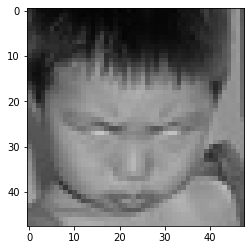

In [10]:
show(*dataset[0])

In [11]:
from torch.utils.data import *  
random_seed = 42
torch.manual_seed(random_seed)

In [12]:
val_size = 3000
train_size = len(dataset)-val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)

(25709, 3000)

In [13]:
# Setting Batch Size 
batch_size = 128

In [14]:
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_dl = DataLoader(val_ds,batch_size*2,num_workers=2,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [15]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images,labels in dl:
    fig,ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

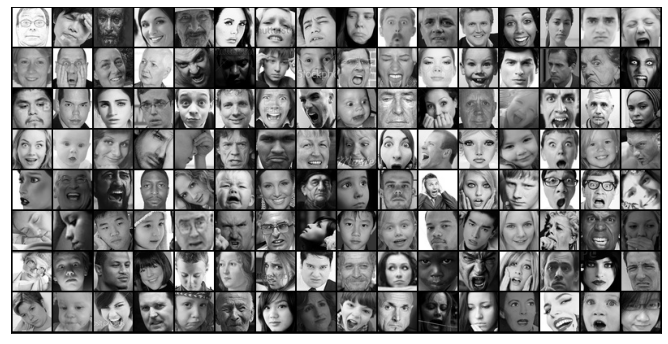

In [16]:
show_batch(train_dl)

In [17]:
def apply_kernel(image,kernel):
   ri,ci=image.shape
   rk,ck = kernel.shape
   ro,co = ri-rk+1,ci-ck+1
   output =torch.zeros([ro,co]) 
   for i in range(ro):
     for j in range(co):
       output[i,j]=torch.sum(image[i:i+rk,j:j+ck]*kernel)
   return output


In [18]:
import torch.nn as nn
import torch.nn.functional as F 

In [19]:
conv = nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1) #Conv layer

In [20]:
pool = nn.MaxPool2d(2,2)

In [21]:
# Simple model with convolutional, and maxpool
simple_model = nn.Sequential(
    conv,
    pool
)

In [22]:
    # for images,label in train_dl:
    #   out = conv(images)
    #   out = pool(out)
    #   print(out.shape)
    #   break 


In [23]:
for images,labels in train_dl:
  print('images.shape',images.shape)
  out = simple_model(images)
  print('out.shape',out.shape)
  break

images.shape torch.Size([128, 3, 48, 48])
out.shape torch.Size([128, 8, 24, 24])


In [24]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [25]:
class ImageClassificationBase(nn.Module):
  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss':loss.detach(),'val_acc':acc}
  
  def validation_epoch_end(self,outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc']for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}
  
  def epoch_end(self,epoch,result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
   

In [26]:
class facialEmotionRecognition(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Flatten(),
        nn.Linear(128*6*6,768),
        nn.ReLU(),
        nn.Linear(768,7))
    
  def forward(self,xb):
    return self.network(xb)

In [27]:
model = facialEmotionRecognition()
model

facialEmotionRecognition(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=4608, out_features=768, bias=True)
    (11): ReLU()
    (12): Linear(in_features=768, out_features=7, bias=True)
  )
)

In [28]:
for images,labels in train_dl:
  print(images.shape)
  out = model(images)
  print(out.shape)
  print(out[0])
  break

torch.Size([128, 3, 48, 48])
torch.Size([128, 7])
tensor([ 0.0325,  0.0332, -0.0324,  0.0152,  0.0174,  0.0245,  0.0401],
       grad_fn=<SelectBackward0>)


In [29]:
def evaluate(model, valid_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_dl]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_dl, valid_dl, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, valid_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [30]:
torch.cuda.is_available()

True

In [31]:
# GPU ENABLED TRAINING
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
  def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

  def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [32]:
device = get_default_device()
device

device(type='cuda')

In [33]:
# Loading batches of data into the GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [34]:
model = to_device(facialEmotionRecognition(),device)

In [35]:
evaluate(model,val_dl)

{'val_loss': 1.9531314373016357, 'val_acc': 0.1470080465078354}

In [36]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [37]:
history=fit(num_epochs,lr,model,train_dl,val_dl,opt_func)

Epoch [0], val_loss: 1.5292, val_acc: 0.4031
Epoch [1], val_loss: 1.3660, val_acc: 0.4627
Epoch [2], val_loss: 1.2917, val_acc: 0.5113
Epoch [3], val_loss: 1.2597, val_acc: 0.5184
Epoch [4], val_loss: 1.1969, val_acc: 0.5583
Epoch [5], val_loss: 1.2693, val_acc: 0.5479
Epoch [6], val_loss: 1.2935, val_acc: 0.5453
Epoch [7], val_loss: 1.3848, val_acc: 0.5535
Epoch [8], val_loss: 1.5787, val_acc: 0.5551
Epoch [9], val_loss: 1.7926, val_acc: 0.5472


In [38]:
test_dataset = ImageFolder(data_dir+'/train',transform=ToTensor())

In [39]:
def predictImage(img,model):
  xb = to_device(img.unsqueeze(0),device)
  yb=model(xb)
  _,preds = torch.max(yb,dim=1)
  return dataset.classes[preds[0].item()]

Actual_LABEL sad  Predicted:  sad


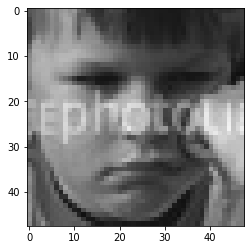

In [40]:
img,label = test_dataset[25000]
plt.imshow(img.permute(1,2,0))
print("Actual_LABEL",dataset.classes[label]," Predicted: ",predictImage(img,model))

In [57]:
from PIL import Image
from torchvision import transforms
img = Image.open('/content/drive/MyDrive/IMG_20221116_153622.jpg')
print(img)
resized = img.resize((48,48))
resized.show()

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=5184x3880 at 0x7FE1CDF0DCD0>


'happy'

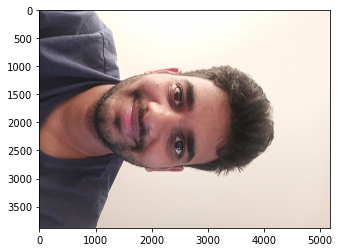

In [82]:
convertToTensor = transforms.ToTensor()
img_tensor = convertToTensor(resized)
actual_image=convertToTensor(img)
# print(img_tensor)
plt.imshow(actual_image.permute(1,2,0))
predictImage(img_tensor,model)